# Recommender system - personalized content-based module

## Introduction ##
With restaurant’s metadata and a rich set of restaurant reviews by unique users, a content based recommender module is built here to recommend restaurants that are similar to user’s preference inferred from user’s past ratings. <br>

## Summary ##

### 1. Three content-based personalized ranking strategies are experimented: (section \#3, \#4 and \#5)

1) (section \#3) generate recommendation ranking based on the descending order of **cosine similarity scores between user feature vector and restaurant feature vector**, where the restaurant feature vectors are **the top 300 PCA components out of the 1000 word features (mono & bigrams) extracted from restaurant reviews by Tfidf vectorizer**, and the user feature vectors are computed by **aggregating feature vectors of user-rated restaurants weighted by the corresponding user rating**<br>

2) (section \#4) generate recommendation ranking based on the descending order of **cosine similarity scores between user feature vector and restaurant feature vector**, where the restaurant feature vectors are **the top 300 word features (monogram only) extracted from all the available restaurant text-based metadata by count vectorizer**, and the user feature vectors are computed by **aggregating the feature vectors of user-rated restaurants weighted by the corresponding user rating**<br>

3) (section \#5) generate recommendation ranking based on the **predicted user rating of restaurants** using supervised regression models which **take use of the above cosine similarity scores as engineered features to enable personalization, along with other features from restaurant numerical metadata**. In this case, RMSE(root-mean-squared-error) is used for model selection.<br>

### 2. Evaluating content-based recommendation strategies by NDCG:  (section \#6)

NDCG (Normalized Discounted Cumulative Gain), which works well with review ratings of 1-5 in this scenario, is chosen over MAP (Mean average precision), which assumes only binary relevance (interesting or not, click or not), as the metrics for evaluating rank quality of the above three strategies.<br> 

For each strategy, NDCG@top10 and NDCG@top5 are computed for the testset. The results reveal that the ranking generated by similarity based on feature vectors extracted from restaurant reviews (strategy 1) is consistently the best among all three ranking strategies (NDCG@10=0.857$\pm$0.085, NDCG@5=0.863$\pm$0.109), whereas the ranking generated by similarity scores based on feature vectors extracted from restaurant text metadata (strategy 2) is the worse among three (NDCG@10=0.848$\pm$0.087, NDCG@5=0.856$\pm$0.111).<br> 

This is likely due to the observation that many of the restaurant metadata information can actually be extracted from restaurant reviews. Thanks to the rich set of reviews Yelp dataset offers, most restaurant features plus a lot more information indicating restaurant quality can be effectively picked up from abundant reviews for building restaurant and user feature space.<br>

### 3. Implementation & testing of the content-based recommender module: (section \#7)

The best-performing ranking strategy by descending cosine-similarity score between user and restaurant based on their review-based feature vectors are chosen for implementing the content-based recommender module. Prior to implementation, the restaurant and user feature vectors are updated taking advantage of all restaurant reviews data (previously only the training set was used) and saved to file for later use.<br>

**Implementaion of content-based recommender module:**<br> 
The restaurant and user feature vectors are first loaded into the module; given the user_id of interest, all cosine similarity scores are then computed between this user and all restaurants in the catalog, and added back to the catalog as a restaurant feature; the restaurant catalog is then filtered to unrated restaurants only based on the user_id of interest, and ranked by descending similarity scores to generate the final recommendation for the given user.<br>

**Testing:**<br>
Module testing shows that the loading of restaurant and user feature vector takes 20 seconds on average on Mac Pro with 2-score CPU and 8Gb memory, whereas the actual time of computing and returning the recommendation for a given user only takes less than 5 seconds. The returning results all feature very personalized recommendations based on preference imputed from user rating history.<br>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
from tqdm import tqdm

In [2]:
business = pd.read_csv('business_clean.csv')  # contains business data including location data, attributes and categories
review = pd.read_csv('review_clean.csv') # contains full review text data including the user_id that wrote the review and the business_id the review is written for

# 1. Extract a subset of 'review' related to restaurant business

The 'review' dataset contains many reviews on non-restaurant businesses. For content-based recommender based on restaurant reviews and metadata, these non-restaurant reviews are not relevant. 

In [3]:
%%time
# extract a subset of reviews related to restaurant-type business
review_s = review[review.business_id.isin(business.business_id.unique())].reset_index(drop=True)
print(len(review), len(review_s))

# free up temporary variable to save on memory use
review = None

5996995 3469589
CPU times: user 7.06 s, sys: 22.1 s, total: 29.2 s
Wall time: 47 s


note: this effectively reduces the number of review records in the 'review' dataframe from 5,996,995 down to 3,469,589.

In [4]:
# update 'postal_code' column in the 'business' dataset as string object type
business['postal_code'] = business.postal_code.astype('str')

# 2. Train-test-split

As the content-based recommendation ranking only works with existing users and restaurants, we need to **create a train-test split where no new users and no new businesses are present in the testset**. To achieve this:<br>

1) first, all the restaurant reviews (the 'review_s' dataset) are first randomly split by 87-13 ratio.<br> 
2) then, the reviews in the testset with new users and new restaurants that are not present in the trainset are moved from the testset back to the trainset.<br>
3) this results in a final train:test ratio of 89:11, with no new users and no new restaurants in the testset.<br>

## 2.1 Initialize with a random train-test-split

In [5]:
%%time
# shuffle the index of review_s for random split
np.random.seed(42)
idx = np.array(review_s.index, dtype='int')
np.random.shuffle(idx)

# start with a train-test-split by 87%-13% ratio
train = review_s.loc[idx[:int(0.87*len(idx))]]
test = review_s.loc[idx[int(0.87*len(idx)):]]
print("current train:test ratio:", len(train)/len(test))

current train:test ratio: 6.692300358942638
CPU times: user 7.13 s, sys: 11.9 s, total: 19 s
Wall time: 25.6 s


## 2.2 Move reviews of user_id that only exists in testset back to trainset

In [6]:
%%time
# add one review of user_id that only exists in testset back to trainset

# determine the idx to move from testset to trainset
user_test_only = test[~test.user_id.isin(train.user_id.unique())] # filter testset to reviews by user_id only exists in the testset
user_idx_toadd = user_test_only['user_id'].drop_duplicates().index # extract the index of the reviews to add back to the trainset

# update the new list of indices for the trainset and testset
idx_train = train.index.union(user_idx_toadd)
idx_test = review_s.index.difference(idx_train)

# update trainset and testset
train = review_s.loc[idx_train]
test = review_s.loc[idx_test]
print("current train:test ratio:", len(train)/len(test))

current train:test ratio: 8.206157446593982
CPU times: user 7.39 s, sys: 24.8 s, total: 32.2 s
Wall time: 56.1 s


## 2.3 Move reviews of business_id that only exists in testset back to trainset

In [7]:
%%time
# add at least one review of business_id that only exists in testset back to trainset

# determine the idx to move from testset to trainset
rest_test_only = test[~test.business_id.isin(train.business_id.unique())] # filter testset to reviews by user_id only exists in the testset
rest_idx_toadd = rest_test_only['business_id'].drop_duplicates().index # extract the index of the reviews to add back to the trainset

# update the new list of indices for the trainset and testset
idx_train = train.index.union(rest_idx_toadd)
idx_test = review_s.index.difference(idx_train)

# update trainset and testset
train = review_s.loc[idx_train]
test = review_s.loc[idx_test]

CPU times: user 3.78 s, sys: 10 s, total: 13.8 s
Wall time: 20.3 s


In [8]:
# calculate the final train vs test sample ratio
print('final train/test ratio:', len(train)/len(test))
assert (len(train) + len(test)) == len(review_s)

final train/test ratio: 8.20627958564181


As shown, the final trainset vs. testset ratio is 8.2063, corresponding to a 89%-11% train-set split. 

# 3. Building restaurant and user feature vectors from restaurant reviews

## 3.1 combine reviews for each restaurants

In [9]:
# groupby business_id and concatenate all reviews of the same business together, reviews are separated by '###'
rev_by_rest = train.groupby('business_id').agg({'review_id': 'count', 'text': lambda i: '###'.join(i)}).rename(columns={'review_id':'review_count','text':'review_combined'})
rev_by_rest = rev_by_rest.reset_index()
rev_by_rest.head(1)

,business_id,review_count,review_combined
0,--7zmmkVg-IMGaXbuVd0SQ,47,"Great beer, great place, excellent service fro..."


## 3.2 Tfidf to extract top features from reviews

In [10]:
%%time
# Tfidf to extract top 1000 features from restaurant reviews
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=1000) # limit to top 1000 words
X = vectorizer.fit_transform(rev_by_rest.review_combined)
print(vectorizer.get_feature_names()[:50]) # inspect the top 50 features

['00', '10', '10 minutes', '100', '11', '12', '15', '15 minutes', '20', '20 minutes', '25', '30', '30 minutes', '40', '45', '50', '99', 'able', 'absolutely', 'actually', 'add', 'added', 'addition', 'afternoon', 'ago', 'ahead', 'airport', 'amazing', 'ambiance', 'american', 'apparently', 'appetizer', 'appetizers', 'area', 'aren', 'arrived', 'asada', 'asian', 'ask', 'asked', 'asking', 'ate', 'atmosphere', 'attention', 'attentive', 'attitude', 'authentic', 'available', 'average', 'avocado']
CPU times: user 10min 16s, sys: 2min 33s, total: 12min 49s
Wall time: 15min 19s


In [11]:
# convert to a sparse dataframe
rest_revfeature = pd.SparseDataFrame(X)
rest_revfeature = rest_revfeature.set_index(rev_by_rest.business_id)
rest_revfeature.columns = vectorizer.get_feature_names()
rest_revfeature = rest_revfeature.fillna(0) # fill in missing values with 0 to use PCA

In [12]:
# look at all the bigrams being picked up in the top 1000 features
for i in rest_revfeature.columns:
    if len(i.split())>1:
        print(i, end=',')

10 minutes,15 minutes,20 minutes,30 minutes,best ve,customer service,definitely recommend,don know,don think,fast food,feel like,felt like,food amazing,food came,food delicious,food good,food great,food just,food service,fried chicken,fried rice,friendly staff,good food,good place,good service,great food,great place,great service,happy hour,highly recommend,ice cream,just right,las vegas,little bit,long time,looked like,love place,mac cheese,make sure,mexican food,place great,pretty good,quality food,really enjoyed,really good,really nice,recommend place,right away,service excellent,service food,service good,service great,staff friendly,super friendly,tasted like,try place,ve tried,wait staff,

In [13]:
# free up temporary variables to save on memory use
X = None
vectorizer = None
rev_by_rest = None

## 3.3 feature reduction with PCA

In [14]:
%%time
# feature selection
from sklearn.decomposition import PCA
pca = PCA()
rest_pcafeature = pca.fit_transform(rest_revfeature)
vr = pca.explained_variance_ratio_

CPU times: user 14.5 s, sys: 1.71 s, total: 16.2 s
Wall time: 13.4 s


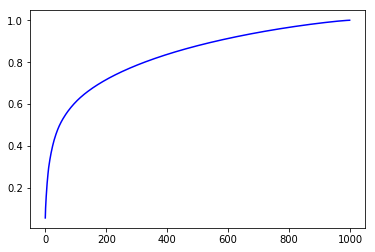

In [15]:
# compute cumulative explained variance ratio
vr_cum = [sum(vr[:i+1]) for i in range(len(vr))]
# plot explained variance ratio vs the number of PCA components
plt.plot(list(range(len(vr))),vr_cum, color='blue'); 

As shown, the first 300 PCA components are responsible for the 80% of the variation. Therefore, the first 300 components will be kept as the restaurant features and the rest less relevant components will be dropped. 

In [16]:
# extract and inspect the top 6 PCA components, in relationship to the original review features
components = pd.DataFrame(data=pca.components_, columns = rest_revfeature.columns)
for i in range(6):
    component = components.loc[i].sort_values(ascending=False)
    print("principle component #{}:\n".format(i), component[:5])

principle component #0:
 pizza       0.750790
crust       0.106085
pizzas      0.081179
delivery    0.077048
toppings    0.045206
Name: 0, dtype: float64
principle component #1:
 pizza      0.537485
food       0.374550
good       0.184521
chicken    0.169766
ordered    0.134355
Name: 1, dtype: float64
principle component #2:
 bar       0.439833
beer      0.216703
great     0.168844
drinks    0.168225
night     0.152813
Name: 2, dtype: float64
principle component #3:
 coffee       0.343310
sandwich     0.255072
order        0.199278
breakfast    0.185238
location     0.178457
Name: 3, dtype: float64
principle component #4:
 hotel    0.384352
room     0.335998
rooms    0.193565
stay     0.182034
desk     0.155869
Name: 4, dtype: float64
principle component #5:
 tacos      0.350580
mexican    0.284093
taco       0.267722
burrito    0.220602
salsa      0.211116
Name: 5, dtype: float64


In [17]:
# keep only the top 300 PCA components
rest_pcafeature = pd.DataFrame(rest_pcafeature[:,:300], index=rest_revfeature.index, columns=[str(i) for i in np.arange(1,301)])
rest_pcafeature.columns.name = 'pca_components'

In [18]:
# rescale rest_pcafeature coefficients so all restaurant feature vectors share the same unit length of 1
rest_pcafeature['root_squared_sum'] = rest_pcafeature.apply(lambda row: np.sqrt(sum([i*i for i in row])), axis=1)
rest_pcafeature = rest_pcafeature.drop('root_squared_sum',axis=1).divide(rest_pcafeature.root_squared_sum, axis=0)
rest_pcafeature.head(1)

pca_components,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
business_id,,,,,,,,,,,,,,,,,,,,,
--7zmmkVg-IMGaXbuVd0SQ,-0.059117,-0.105398,0.422339,-0.163535,-0.150402,0.15404,-0.049404,-0.074484,-0.119477,-0.036121,...,0.001167,0.012947,-0.003036,0.007732,0.030837,0.01339,0.017888,0.001863,0.008954,-0.018501


## 3.4 compute user feature vector

In [19]:
%%time
# build user preference profile by compute a weighted sum of the restaurant vectors for all rated items by the user, with weights being the user’s rating
user_pcafeature = pd.merge(train[['user_id','business_id','stars']], rest_pcafeature, how='inner',left_on='business_id',right_index=True).drop('business_id', axis=1)

CPU times: user 9.95 s, sys: 17.8 s, total: 27.7 s
Wall time: 39.2 s


In [20]:
%%time
# rescale component coefficients by the review rating as the correpsonding weight
user_pcafeature.loc[:, '1':'300'] = user_pcafeature.loc[:,'1':'300'].multiply(user_pcafeature.stars, axis=0)

CPU times: user 18.4 s, sys: 56.9 s, total: 1min 15s
Wall time: 1min 40s


In [21]:
%%time
# sum up all component coefficients by user_id
user_pcafeature = user_pcafeature.drop('stars', axis=1).groupby('user_id').sum()

CPU times: user 52.5 s, sys: 4min 32s, total: 5min 24s
Wall time: 15min 7s


In [22]:
# rescale user_pcafeature coefficients so all user feature vectors share the same unit length of 1
user_pcafeature['root_squared_sum'] = user_pcafeature.apply(lambda row: np.sqrt(sum([i*i for i in row])), axis=1)
user_pcafeature = user_pcafeature.drop('root_squared_sum', axis=1).divide(user_pcafeature.root_squared_sum, axis=0)
user_pcafeature.head(1)

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,-0.127453,0.277403,0.20038,-0.093381,-0.248164,-0.077411,0.217152,0.257582,0.218357,0.167718,...,0.006834,0.006594,-0.02086,-0.001917,0.010947,0.012562,0.009829,-0.006487,0.009611,-0.020761


### Discussions on the weights to use for aggregating users' preference from review ratings: 

As shown above, the weights used for aggregating users' preference is simply the star ratings the users gave along with the reviews. This does not take into consideration that different users might have different rating criteria and scale, some are more generous and some are more critical. <br>
But as discussed below, this is considered a simple and more effective approach than other alternatives weights.

#### Alternative \#1: use user's review rating of a restaurant minus 3 as the weight of the restaurant when aggregating

In [23]:
# user_pcafeature.loc[:, '1':'300'] = user_pcafeature.loc[:,'1':'300'].multiply(user_pcafeature.stars-3, axis=0)

Note: alternative \#1 is very similar to the simple star rating as the weights, except that it offsets the weight from positive scale of 1 to 5 to a scale of -2 to 2. Therefore, it does not take into consideration that different users might have different rating criteria and scale either. In addition, the preference indicated by review ratings of 3 is lost because those weights will become 0. Therefore, this alternative method of modifying weights is not adopted here.

#### Alternative \#2: use user's review rating of a restaurant minus the mean rating of that user as the weight of the restaurant when aggregating

In [24]:
# # compute mean ratings by user
# user_mean_rating = train.groupby('user_id').stars.mean().rename(columns={'stars':'user_mean_rating'})
# user_pcafeature = pd.merge(user_pcafeature, user_mean_rating, how='inner', left_on='user_id', right_index=True)
# weights = user_pcafeature.stars - user_pcafeature.user_mean_rating

# # then rescale the feature vector by the review rating as the correpsonding weight
# user_pcafeature.loc[:, '1':'300'] = user_pcafeature.loc[:,'1':'300'].multiply(weights, axis=0)

Note: although alternative method \#2 of adjusting the weights takes into consideration that different users might have different rating criteria and scale, some are more generous and some are more critical, it causes potential problems as well: <br>
1) some Yelp users only go to Yelp to review restaurants when they have really positive experiences. By substracting the user's mean rating, this strong preference is arbituarily removed.<br>
2) similar to 1), some users only reviews when they have really negative experiences, this strong dislikes will be removed by substracting the user mean as well.<br>
3) there are a substaintial amount of users (547,561 users) in the 'review' dataset that only has one review/rating in total, these users' preference will be lost since substracting user mean will result in zero weights.<br> 
Therefore, this alternative method of adjusting weights is not used in this project. 

## 3.5 Save restaurant and user pca features to file
Note:<br> 
the feature vectors from training on the trainset are saved to 'rest_pcafeature_train.pkl' and 'user_pcafeature_train.pkl' for evaluation purposes on the testset;<br>
Later, the feature vectors are re-trained taking adventage of the entire restaurant review dataset and are saved as 'rest_pcafeature_all.pkl' and 'user_pcafeature_all.pkl' for implementation in the actual content-based recommender module.

In [25]:
%%time

# save rest_pcafeature as pickled file
with open('rest_pcafeature_train.pkl','wb') as f:
    pickle.dump(rest_pcafeature, f)
    
# save user_pcafeature as pickled file, note: need to write in chucks of size smaller than 2GB due to a bug in Python3
max_bytes = 2**31 - 1
bytes_out = pickle.dumps(user_pcafeature)
with open('user_pcafeature_train.pkl','wb') as f:
    for idx in range(0, len(bytes_out), max_bytes):
        f.write(bytes_out[idx:idx+max_bytes])

CPU times: user 4.91 s, sys: 19.9 s, total: 24.8 s
Wall time: 53.8 s


In [26]:
# free up temporary variables to save on memory use
rest_revfeature = None
components = None
vr = None
vr_cum = None
pca = None
rest_pcafeature = None
user_pcafeature = None

# 4. Building restaurant and user feature vector from restaurant metadata

**There are two types of metadata in the 'business' dataset:** <br>

1) numerical metadata: <br>
columns include 'latitude','longitude', 'stars' and 'review_count'. <br>
2) text-based metadata: <br>
all other columns contain some types of text-based information, either nested dictionaries, or categorical values, or True or False booleans. In particular, columns containing nested dictionaries ('hour' and 'attributes') have been unpacked and all information is extracted.<br>

Note: only text-based metadata are extracted and used here to build restaurant and user feature vectorse, whereas the numerical metadata are separated for use later in the supervised regression model. 

## 4.1 Transform text-based metadata of restaurants

### 4.1.1 Copy the 'business_id', 'postal_code', 'city', 'state', 'name','neighborhood' and 'categories' columns
No transformation is necessary for these columns.

In [27]:
rest_metadata = business[['business_id','postal_code','city','state','name','neighborhood','categories']]

### 4.1.2 Drop the 'address' column

In [28]:
business.address.head(3)

0                                NaN
1    20235 N Cave Creek Rd, Ste 1115
2                 1440 N. Dysart Ave
Name: address, dtype: object

As shown, restaurant address typically doesn't contain useful restaurant features, therefore the 'address' column is not used for feature extraction. 

### 4.1.3 Transform the 'hours' column

In [29]:
# transform the 'hours' column (and all child columns named 'hours.*')

def hours_transform(row):
    """function to transform and extract information from the 'hours' column (and all child columns named 'hours.*')
    of the 'business' dataframe"""
    row.hours = ''
    for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
        col = 'hours.{}'.format(day)
        if row[col] is not np.nan:
            row.hours += day + ','
    if len(row.hours) > 0:
        row.hours = row.hours[:-1] # trim off the extra comma ',' at the end
    return row

# apply the transform and add the transformed column to rest_metafeature
rest_metadata['hours'] = business.apply(hours_transform, axis=1).hours
rest_metadata.hours.head(2)

0                               Friday,Saturday,Sunday
1    Monday,Tuesday,Wednesday,Thursday,Friday,Satur...
Name: hours, dtype: object

### 4.1.4 Transform the 'attributes' columns
There are two types of child columns (named 'attributes.*') extracted from the 'attributeds' column:<br>
**1) columns with categorical values** child columns belonging to this type are: <br>
'WheelchairAccessible', 'HappyHour', 'Alcohol','NoiseLevel', 'HasTV', 'RestaurantsPriceRange2', 'CoatCheck', 'Open24Hours', 'RestaurantsReservations', 'GoodForDancing', 'WiFi', 'RestaurantsAttire', 'RestaurantsDelivery', 'RestaurantsTakeOut', 'Smoking', 'BusinessAcceptsCreditCards', 'BusinessAcceptsBitcoin', 'GoodForKids', 'AgesAllowed', 'Caters', 'DogsAllowed', 'BikeParking', 'OutdoorSeating', 'RestaurantsGoodForGroups', 'RestaurantsCounterService', 'ByAppointmentOnly', 'RestaurantsTableService', 'DriveThru'.<br>
For instance, 'attributes.GoodForDancing' column has binary True or False values, 'attribute.NoiseLevel' column take a categorical value from possible values of \['average','quite','loud','very_loud'\].

**2) columns with dictionaries as values** child columns belonging to this type are: <br>
'DietaryRestrictions', 'GoodForMeal', 'BusinessParking', 'BestNights', 'Music', 'Ambience'. <br>
All these dictionaries have True or False binary booleans as their values.<br>
For instance, 'attributes.GoodForMeal' column contains nested dictionaries with possible key valuess among 'dessert', 'latenight','lunch','dinner','breakfast' and 'brunch', and True or False binary booleans as the values under these keys.<br>

In addition, there are three related child columns regarding the 'bring your own bottle' services:
These columns are 'attributes.BYOB', 'attributes.Corkage' and 'attributes.BYOBCorkage'. The consistency check among these three columns are performed. 

In [30]:
# look at 'BYOB' (bring your own bottle) and 'Corkage' (fee charged for BYOB) related columns
print(len(business[['attributes.BYOBCorkage','attributes.BYOB','attributes.Corkage']].dropna(how='all')))
business.groupby(['attributes.BYOBCorkage','attributes.BYOB','attributes.Corkage'])['business_id'].count()

1409


attributes.BYOBCorkage  attributes.BYOB  attributes.Corkage
no                      False            False                  54
                                         True                   14
yes_corkage             False            True                   57
                        True             True                   18
yes_free                False            False                 323
                                         True                    3
                        True             False                  12
                                         True                    3
Name: business_id, dtype: int64

As shown, data in these three columns are not consistent, and there are only a total of 1409 non-null combinations (3%) out of 47553 entries, therefore information in these columns are not incorporated for analysis.

In [31]:
%%time

# transform the child columns (named 'attributes.*') with categorical values

def attributes_transform_cate(row):
    row.attributes=''
    
    # names of the child columns to be transformed
    cat_cols = ['WheelchairAccessible','HappyHour','Alcohol','NoiseLevel','HasTV','RestaurantsPriceRange2','CoatCheck',\
               'Open24Hours','RestaurantsReservations','GoodForDancing','WiFi','RestaurantsAttire','RestaurantsDelivery',\
               'RestaurantsTakeOut','Smoking','BusinessAcceptsCreditCards','BusinessAcceptsBitcoin','GoodForKids',\
                'AgesAllowed','Caters','DogsAllowed','BikeParking','OutdoorSeating','RestaurantsGoodForGroups',\
               'RestaurantsCounterService','ByAppointmentOnly','RestaurantsTableService','DriveThru']
    
    # transform all child columns with categorical values (binary, or categorical)
    for attr in cat_cols:
        col = 'attributes.{}'.format(attr)
        if row[col] is not np.nan:
            row.attributes += attr + '_' + str(row[col]) + ','  

    if len(row.attributes) > 0:
        row.attributes = row.attributes[:-1]
    
    return row

# apply the transform and add the transformed column as 'attr_cate' to dataframe 'rest_metadata'
rest_metadata['attr_cate'] = business.apply(attributes_transform_cate, axis=1).attributes

CPU times: user 42.4 s, sys: 1.75 s, total: 44.1 s
Wall time: 47.1 s


In [32]:
rest_metadata.attr_cate.iloc[0] # inspect the result

'WheelchairAccessible_True,Alcohol_none,HasTV_False,RestaurantsPriceRange2_2.0,RestaurantsReservations_False,WiFi_no,RestaurantsAttire_casual,RestaurantsDelivery_False,RestaurantsTakeOut_True,BusinessAcceptsCreditCards_True,GoodForKids_True,Caters_True,DogsAllowed_True,BikeParking_False,OutdoorSeating_True,RestaurantsGoodForGroups_True,RestaurantsTableService_False,DriveThru_False'

In [33]:
%%time

# transform the child columns (named 'attributes.*') with nested dictionaries

# define a function to extract the nested dictionaries from the string
# note: all the nested dictionaries share a similar format as: {'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'breakfast': False, 'brunch': False}
# however, this string is not a valid JSON format and cannot be parsed by json.loads(), not even after replacing single quote ' with double quote ", because the values 'True' and 'False' are not coded as strings with double quotes
# Therefore, a customized function is written for extracting the nested dictionaries from the strings.

def convert_to_dict(s):
    """convert a non-null string of special format (invalid JSON format) to a dictionary.
    """
    a = [i.strip() for i in s[1:-1].split(',')] # extract content between '{' and '}' and split by comma ','
    b = [i.split(':') for i in a]
    for i in b: 
        i[0] = i[0].strip('\'')
        i[1] = bool(i[1].strip())
    return dict(b)

def attributes_transform_dict(row):
    row.attributes=''
    
    # names of the child columns to be transformed
    dict_cols = ['DietaryRestrictions','GoodForMeal','BusinessParking','BestNights','Music','Ambience']
    
    # transform child columns with nested dictionaries
    for attr in dict_cols:
        col = 'attributes.{}'.format(attr)
        if row[col] is not np.nan:
            row[col] = convert_to_dict(row[col])
            for k,v in row[col].items():
                if v is not np.nan:
                    row.attributes += attr + '_' + k + '_' + str(v) + ',' 

    if len(row.attributes) > 0:
        row.attributes = row.attributes[:-1]
    
    return row

# apply the transform and add the transformed column as 'attr_dict' to dataframe 'rest_metadata'
rest_metadata['attr_dict'] = business.apply(attributes_transform_dict, axis=1).attributes

CPU times: user 39.6 s, sys: 2.27 s, total: 41.9 s
Wall time: 46.2 s


In [34]:
rest_metadata.attr_dict.iloc[0] # inspect the result

'GoodForMeal_dessert_True,GoodForMeal_latenight_True,GoodForMeal_lunch_True,GoodForMeal_dinner_True,GoodForMeal_breakfast_True,GoodForMeal_brunch_True,BusinessParking_garage_True,BusinessParking_street_True,BusinessParking_validated_True,BusinessParking_lot_True,BusinessParking_valet_True'

In [35]:
rest_metadata = rest_metadata.set_index('business_id') # set 'business_id' as the index col
rest_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47553 entries, AjEbIBw6ZFfln7ePHha9PA to 3_fIsSxN2RBovQ_6EFtLzA
Data columns (total 9 columns):
postal_code     47553 non-null object
city            47553 non-null object
state           47553 non-null object
name            47553 non-null object
neighborhood    15832 non-null object
categories      47137 non-null object
hours           47553 non-null object
attr_cate       47553 non-null object
attr_dict       47553 non-null object
dtypes: object(9)
memory usage: 3.6+ MB


In [36]:
# combine all columns into a single column of all text features
rest_metadata['metafeature'] = rest_metadata.apply(lambda row: ','.join([str(i) for i in row if i is not np.nan]), axis=1)
rest_metadata.metafeature.head(2)

business_id
AjEbIBw6ZFfln7ePHha9PA    89002,Henderson,NV,CK'S BBQ & Catering,Chicken...
45bWSZtniwPRiqlivpS8Og    85024,Phoenix,AZ,The Coffee Bean & Tea Leaf,Co...
Name: metafeature, dtype: object

## 4.2 Use CountVectorizer to extract restaurant feature vector from text-based metadata

In [37]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=['the','and','in','of','at','by','city','el'],lowercase=True, max_features=300)
X = vectorizer.fit_transform(rest_metadata.metafeature)
print(vectorizer.get_feature_names()[:100]) # inspect the top 100 features

['15222', '28202', '28277', '44113', '53703', '61820', '85004', '85016', '85032', '85251', '85260', '85281', '85308', '89014', '89101', '89102', '89103', '89104', '89109', '89119', '89123', '89146', 'alcohol_beer_and_wine', 'alcohol_full_bar', 'alcohol_none', 'ambience_casual_true', 'ambience_classy_true', 'ambience_divey_true', 'ambience_hipster_true', 'ambience_intimate_true', 'ambience_romantic_true', 'ambience_touristy_true', 'ambience_trendy_true', 'ambience_upscale_true', 'american', 'arts', 'asian', 'az', 'bagels', 'bakeries', 'bakery', 'bar', 'barbeque', 'bars', 'bbq', 'beer', 'bestnights_friday_true', 'bestnights_monday_true', 'bestnights_saturday_true', 'bestnights_sunday_true', 'bestnights_thursday_true', 'bestnights_tuesday_true', 'bestnights_wednesday_true', 'bikeparking_false', 'bikeparking_true', 'bistro', 'breakfast', 'breweries', 'brunch', 'buffet', 'buffets', 'burger', 'burgers', 'businessacceptsbitcoin_false', 'businessacceptscreditcards_false', 'businessacceptscredi

In [38]:
rest_metafeature = pd.SparseDataFrame(X)
rest_metafeature = rest_metafeature.set_index(rest_metadata.index)
rest_metafeature.columns = vectorizer.get_feature_names()
rest_metafeature = rest_metafeature.fillna(0) # fill in missing values with 0 to use PCA

In [39]:
# rescale rest_metafeature coefficients so all restaurant feature vectors share the same unit length of 1
rest_metafeature['root_squared_sum'] = rest_metafeature.apply(lambda row: np.sqrt(sum([i*i for i in row])), axis=1)
rest_metafeature = rest_metafeature.drop('root_squared_sum',axis=1).divide(rest_metafeature.root_squared_sum, axis=0)
rest_metafeature.head(1)

,15222,28202,28277,44113,53703,61820,85004,85016,85032,85251,...,westside,wheelchairaccessible_false,wheelchairaccessible_true,wi,wifi_free,wifi_no,wifi_paid,wine,wings,yogurt
business_id,,,,,,,,,,,,,,,,,,,,,
AjEbIBw6ZFfln7ePHha9PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.141421,0.0,0.0,0.141421,0.0,0.0,0.141421,0.0


In [40]:
# free up temporary variables to save memory use
X = None
vectorizer = None
rest_metadata = None

## 4.3 Aggregate user feature vector based on user ratings of restaurants

In [41]:
# build user preference profile by compute a weighted sum of the restaurant vectors for all rated items by the user, with weights being the user’s rating
user_metafeature = pd.merge(train[['user_id','business_id','stars']], rest_metafeature, how='inner',left_on='business_id',right_index=True).drop('business_id', axis=1)

In [42]:
%%time
# rescale component coefficients by the review rating as the correpsonding weight
user_metafeature.loc[:, '15222':'yogurt'] = user_metafeature.loc[:,'15222':'yogurt'].multiply(user_metafeature.stars, axis=0)

CPU times: user 18.2 s, sys: 33.5 s, total: 51.7 s
Wall time: 49.2 s


In [43]:
%%time
# sum up all component coefficients by user_id
user_metafeature = user_metafeature.drop('stars', axis=1).groupby('user_id').sum()
print(user_metafeature.head(1))

                        15222  28202  28277  44113  53703  61820  85004  \
user_id                                                                   
---1lKK3aKOuomHnwAkAow    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                        85016  85032  85251    ...      westside  \
user_id                                        ...                 
---1lKK3aKOuomHnwAkAow    0.0    0.0    0.0    ...     11.612928   

                        wheelchairaccessible_false  wheelchairaccessible_true  \
user_id                                                                         
---1lKK3aKOuomHnwAkAow                      0.5156                  27.804074   

                         wi  wifi_free    wifi_no  wifi_paid      wine  wings  \
user_id                                                                         
---1lKK3aKOuomHnwAkAow  0.0  11.170815  13.443261        0.0  3.872615    0.0   

                          yogurt  
user_id                           
---1lKK3aKO

In [44]:
%%time
# rescale user_pcafeature coefficients so all user feature vectors share the same unit length of 1
user_metafeature['root_squared_sum'] = user_metafeature.apply(lambda row: np.sqrt(sum([i*i for i in row])), axis=1)
user_metafeature = user_metafeature.drop('root_squared_sum', axis=1).divide(user_metafeature.root_squared_sum, axis=0)
print(user_metafeature.head(1))

                        15222  28202  28277  44113  53703  61820  85004  \
user_id                                                                   
---1lKK3aKOuomHnwAkAow    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                        85016  85032  85251    ...     westside  \
user_id                                        ...                
---1lKK3aKOuomHnwAkAow    0.0    0.0    0.0    ...     0.064394   

                        wheelchairaccessible_false  wheelchairaccessible_true  \
user_id                                                                         
---1lKK3aKOuomHnwAkAow                    0.002859                   0.154175   

                         wi  wifi_free   wifi_no  wifi_paid      wine  wings  \
user_id                                                                        
---1lKK3aKOuomHnwAkAow  0.0   0.061943  0.074544        0.0  0.021474    0.0   

                          yogurt  
user_id                           
---1lKK3aKOuomHnw

## 4.4 Save restaurant meta features and user meta features to file

In [45]:
%%time

# save rest_metafeature as pickled file
with open('rest_metafeature_train.pkl','wb') as f:
    pickle.dump(rest_metafeature, f)

# save user_metafeature as pickled file, note: need to write in chucks of size smaller than 2GB due to a bug in Python3
max_bytes = 2**31 - 1
bytes_out = pickle.dumps(user_metafeature)
with open('user_metafeature_train.pkl','wb') as f:
    for idx in range(0, len(bytes_out), max_bytes):
        f.write(bytes_out[idx:idx+max_bytes])

CPU times: user 4.48 s, sys: 15.6 s, total: 20.1 s
Wall time: 28.6 s


In [46]:
# free up temporary variables to save memory use
rest_metafeature = None
user_metafeature = None

# 5. Rating prediction based on cosine similarity scores and restaurant numerical metadata

Based on the two types of feature vectors built in section \#3 and section \#4 (pcafeature and metafeature, respectively), two similarity scores can be computed for user-restaurant pairs:<br>
1) cosine similarity score computed based on user and restaurant feature vectors extracted from retaurant text-type metadata using count vectorizer<br>
2) cosine similarity score computed based on user and restaurant feature vectors extracted from restaurant reviews using Tfidf vectorizer<br>

Both similarity scores are personalized to individual user-restaurant pairs to present user preference, and can be added as engineered features along with other features for personalized review rating prediction.<br>

## 5.1 Build features from restaurant text metadata-based similarity score and restaurant numerical metadata

Here, the cosine similarity scores are computed for each user-restaurant pair in the train and test set based on their feature vectors extracted from retaurant text-type metadata using count vectorizer. <br> 
This similarity score is added as an engineered feature along with restaurant numerical metadata to take advantage of all the available restaurant metadata for building regression models towards rating prediction.<br>

In [47]:
# restaurant and user metafeature vector developed from restaurant text metadata in section #4 are used to compute pairwise cosine similarity scores (dot product of the restaurant feature vector and user feature vector)
# this similarity scores have been computed for all user-restaurant combinations available in the restaurant review dataset ('review_s')
# the actual computation was completed in a separate notebook, the similarity score along with the corresponding review_id are saved to a pickle file named 'similarity_meta_train.pkl'

with open('similarity_meta_train.pkl','rb') as f: # load in the computed cosine similarity score
    sim_meta_train = pickle.load(f)

sim_meta_train = sim_meta_train.set_index('review_id')

In [48]:
# build features

# extract numerical columns from business
busi_num = business[['business_id','latitude','longitude','stars','review_count']]

# extract only the necessary information for reviews in the train and test set
train_1 = train[['review_id','user_id','business_id','stars']].set_index('review_id')
test_1 = test[['review_id','user_id','business_id','stars']].set_index('review_id')

# merge the similarity scores from restaurant text-based metadata with reviews in the train and test set separately
train_1 = train_1.join(sim_meta_train) # join on index ('review_id')
test_1 = test_1.join(sim_meta_train) # join on index ('review_id')

# merge restaurant numerical metadata with reviews in the train and test set separately
train_1 = train_1.merge(busi_num, how='inner', on='business_id', suffixes=('_review', '_busi')) # join on 'business_id'
test_1 = test_1.merge(busi_num, how='inner', on='business_id', suffixes=('_review', '_busi')) # join on 'business_id'

## 5.2 Regression models for rating prediction based on the engineered features in 5.1

Various linear and non-linear regression models are prototyped for predicting review ratings.

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# import regression models and metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import r2_score, mean_squared_error 

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [50]:
# initiate the score table and define function for logging performance for regression problem
index = ['Lasso','Ridge','RandomForestRegressor','GradientBoostingRegressor']
score_table = pd.DataFrame(index = index, columns= ['r2_train','mse_train','rmse_train','r2_test','mse_test','rmse_test'])

# define function for logging the results
def compute_log_result(algo, pred_train, pred_test):
    """compute and log the performance into the score_table for both training and test sets"""
    
    # compute the performance
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    mse_train = mean_squared_error(y_train, pred_train)
    mse_test = mean_squared_error(y_test, pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    
    # log the performance
    score_table.loc[algo,:] = r2_train, mse_train, rmse_train, r2_test, mse_test, rmse_test

In [51]:
# extract feature and target variables
X_train, y_train = train_1.drop(['user_id','business_id','stars_review'], axis=1), train_1.stars_review
X_test, y_test = test_1.drop(['user_id','business_id','stars_review'], axis=1), test_1.stars_review

# fit Lasso regression model with optimized parameters
lasso = Pipeline([('scaler', StandardScaler()),('lasso', Lasso(alpha=0.0015, max_iter=1000, selection='random'))])
lasso.fit(X_train, y_train)
pred_train = lasso.predict(X_train)
pred_test = lasso.predict(X_test)
# print features oefficients 
feature_coef = pd.DataFrame({'feature':X_train.columns, 'coefficient':lasso.named_steps.lasso.coef_})
print("feature coefficients for the fitted Lasso model:\n",feature_coef.sort_values('coefficient',ascending=False))
# logging of model performance
compute_log_result("Lasso", pred_train, pred_test)

# fit Ridge regression model with optimized parameters
ridge = Pipeline([('scaler', StandardScaler()),('ridge',Ridge(alpha=100,max_iter=1000,tol=0.001))])
ridge.fit(X_train, y_train)
pred_train = ridge.predict(X_train)
pred_test = ridge.predict(X_test)
# print features and coefficients
feature_coef = pd.DataFrame({'feature':X_train.columns, 'coefficient':ridge.named_steps.ridge.coef_})
print("feature coefficients for the fitted Ridge model:\n", feature_coef.sort_values('coefficient',ascending=False))
# logging of model performance
compute_log_result("Ridge", pred_train, pred_test)

# fit random forest regression model with optimized parameters
rfr = Pipeline([('scaler', StandardScaler()),('rfr', RandomForestRegressor(n_estimators=70, max_features='log2'))])
rfr.fit(X_train, y_train)
pred_train = rfr.predict(X_train)
pred_test = rfr.predict(X_test)
# print feature importance
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rfr.named_steps.rfr.feature_importances_})
print("feature importance for the fitted Random Forest Regressor model:\n", feature_rank.sort_values(by='importance',ascending=False))
# logging of model performance
compute_log_result("RandomForestRegressor", pred_train, pred_test)

# fit gradient boosting regression model with optimized parameters
gbr = Pipeline([('scaler', StandardScaler()),('gbr', GradientBoostingRegressor(n_estimators=400, max_features='log2'))])
gbr.fit(X_train, y_train)
pred_train = gbr.predict(X_train)
pred_test = gbr.predict(X_test)
# print feature importance
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': gbr.named_steps.gbr.feature_importances_})
print("feature importance for the fitted Gradient Boosting Regressor model:\n", feature_rank.sort_values(by='importance',ascending=False))
# logging of model performance
compute_log_result("GradientBoostingRegressor", pred_train, pred_test)

score_table # print the performance table for all tested algorithms

feature coefficients for the fitted Lasso model:
                  feature  coefficient
3             stars_busi     0.596122
0  similarity_meta_train     0.085543
1               latitude     0.000195
2              longitude     0.000000
4           review_count    -0.007448
feature coefficients for the fitted Ridge model:
                  feature  coefficient
3             stars_busi     0.597652
0  similarity_meta_train     0.087036
1               latitude     0.002546
2              longitude    -0.001435
4           review_count    -0.009427
feature importance for the fitted Random Forest Regressor model:
                  feature  importance
0  similarity_meta_train    0.537384
3             stars_busi    0.213852
2              longitude    0.086074
1               latitude    0.085068
4           review_count    0.077622
feature importance for the fitted Gradient Boosting Regressor model:
                  feature  importance
0  similarity_meta_train    0.289764
4           

,r2_train,mse_train,rmse_train,r2_test,mse_test,rmse_test
Lasso,0.190492,1.58379,1.25849,0.157949,1.49273,1.22177
Ridge,0.190498,1.58378,1.25848,0.157495,1.49354,1.2221
RandomForestRegressor,0.712084,0.563302,0.750534,-0.271203,2.25351,1.50117
GradientBoostingRegressor,0.21789,1.53018,1.23701,0.143109,1.51904,1.23249


As shown, the simple linear regression models give the best performance, the best RMSE obtained on the testset is 1.222. This is based on the testset with no new users and businesses, due to the limitation of content-based personalized models.<br>

As a cross comparison, the best RMSE obtained on the testset in the collaborative module are:<br>
RMSE = 1.2743 for testset with unseen users and unseen businesses.<br>
RMSE = 0.9270 for testset with no new users and businesses.<br>

## 5.3 Add similarity score based on restaurant reviews as additional feature

As discussed above, two similarity scores are available:<br>
1) cosine similarity scores computed based on user and restaurant feature vectors extracted from retaurant text-type metadata using count vectorizer<br>
2) cosine similarity scores computed based on user and restaurant feature vectors extracted from restaurant reviews using Tfidf vectorizer<br>

In addition to the features crafted in \#5.1 using restaurant numerical metadata and similarity scores from restaurant text metadata, simiarity scores from restaurant reviews are also added as an engineered feature representing personal preference.<br>
Therefore, not only are the entire restaurant metadata incorporated, but also the rich set of restaurant reviews. This enable the model to take advantage of all the available content-based information for personalized rating prediction.

In [52]:
# restaurant and user pcafeature vector developed from restaurant reviews in section #3 are used to compute pairwise cosine similarity scores (dot product of the restaurant feature vector and user feature vector)
# this similarity scores have been computed for all user-restaurant combinations available in the restaurant review dataset ('review_s')
# the actual computation was completed in a separate notebook, the similarity score along with the corresponding review_id are saved to a pickle file named 'similarity_pca_train.pkl'

with open('similarity_pca_train.pkl','rb') as f: # load in the computed similarity score
    sim_pca_train = pickle.load(f)

sim_pca_train = sim_pca_train.set_index('review_id')

In [53]:
# combine all features

# extract numerical columns from business
busi_num = business[['business_id','latitude','longitude','stars','review_count']]

# extract only the necessary information for reviews in the train and test set
train_2 = train[['review_id','user_id','business_id','stars']].set_index('review_id')
test_2 = test[['review_id','user_id','business_id','stars']].set_index('review_id')

# merge the similarity scores from restaurant text-based metadata with reviews in the train and test set separately
train_2 = train_2.join(sim_meta_train).join(sim_pca_train) # join on index ('review_id')
test_2 = test_2.join(sim_meta_train).join(sim_pca_train) # join on index ('review_id')

# merge restaurant numerical metadata with reviews in the train and test set separately
train_2 = train_2.merge(busi_num, how='inner', on='business_id', suffixes=('_review', '_busi')) # join on 'business_id'
test_2 = test_2.merge(busi_num, how='inner', on='business_id', suffixes=('_review', '_busi')) # join on 'business_id'

## 5.4 Regression models for rating prediction based on the engineered features in 5.3

In [54]:
# extract feature and target variables
X_train, y_train = train_2.drop(['user_id','business_id','stars_review'], axis=1), train_2.stars_review
X_test, y_test = test_2.drop(['user_id','business_id','stars_review'], axis=1), test_2.stars_review

# fit Lasso regression model with optimized parameters
lasso = Pipeline([('scaler', StandardScaler()),('lasso', Lasso(alpha=0.003, max_iter=1000, selection='random'))])
lasso.fit(X_train, y_train)
pred_train = lasso.predict(X_train)
pred_test = lasso.predict(X_test)
# print features oefficients 
feature_coef = pd.DataFrame({'feature':X_train.columns, 'coefficient':lasso.named_steps.lasso.coef_})
print("feature coefficients for the fitted Lasso model:\n",feature_coef.sort_values('coefficient',ascending=False))
# logging of model performance
compute_log_result("Lasso", pred_train, pred_test)

# fit Ridge regression model with optimized parameters
ridge = Pipeline([('scaler', StandardScaler()),('ridge',Ridge(alpha=30000,max_iter=1000,tol=0.001))])
ridge.fit(X_train, y_train)
pred_train = ridge.predict(X_train)
pred_test = ridge.predict(X_test)
# print features and coefficients
feature_coef = pd.DataFrame({'feature':X_train.columns, 'coefficient':ridge.named_steps.ridge.coef_})
print("feature coefficients for the fitted Ridge model:\n", feature_coef.sort_values('coefficient',ascending=False))
# logging of model performance
compute_log_result("Ridge", pred_train, pred_test)

# fit random forest regression model with optimized parameters
rfr = Pipeline([('scaler', StandardScaler()),('rfr', RandomForestRegressor(n_estimators=70, max_features='log2'))])
rfr.fit(X_train, y_train)
pred_train = rfr.predict(X_train)
pred_test = rfr.predict(X_test)
# print feature importance
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rfr.named_steps.rfr.feature_importances_})
print("feature importance for the fitted Random Forest Regressor model:\n", feature_rank.sort_values(by='importance',ascending=False))
# logging of model performance
compute_log_result("RandomForestRegressor", pred_train, pred_test)

# fit gradient boosting regression model with optimized parameters
gbr = Pipeline([('scaler', StandardScaler()),('gbr', GradientBoostingRegressor(n_estimators=700, max_features='auto'))])
gbr.fit(X_train, y_train)
pred_train = gbr.predict(X_train)
pred_test = gbr.predict(X_test)
# print feature importance
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': gbr.named_steps.gbr.feature_importances_})
print("feature importance for the fitted Gradient Boosting Regressor model:\n", feature_rank.sort_values(by='importance',ascending=False))
# logging of model performance
compute_log_result("GradientBoostingRegressor", pred_train, pred_test)

score_table # print the performance table for all tested algorithms

feature coefficients for the fitted Lasso model:
                  feature  coefficient
4             stars_busi     0.592181
1   similarity_pca_train     0.158589
3              longitude     0.000000
2               latitude    -0.000422
0  similarity_meta_train    -0.014672
5           review_count    -0.018581
feature coefficients for the fitted Ridge model:
                  feature  coefficient
4             stars_busi     0.589736
1   similarity_pca_train     0.165249
3              longitude     0.002418
2               latitude    -0.005235
5           review_count    -0.021150
0  similarity_meta_train    -0.021602
feature importance for the fitted Random Forest Regressor model:
                  feature  importance
1   similarity_pca_train    0.256307
0  similarity_meta_train    0.231268
4             stars_busi    0.206492
3              longitude    0.104514
2               latitude    0.103452
5           review_count    0.097967
feature importance for the fitted Gradient 

,r2_train,mse_train,rmse_train,r2_test,mse_test,rmse_test
Lasso,0.198382,1.56835,1.25234,0.143007,1.51922,1.23257
Ridge,0.19841,1.5683,1.25232,0.142361,1.52037,1.23303
RandomForestRegressor,0.731392,0.525527,0.724932,-0.155661,2.04868,1.43132
GradientBoostingRegressor,0.242921,1.48121,1.21705,0.0639916,1.65929,1.28814


Similar to the modeling results in \#5.2, here, the simple linear regression models give the best performance, the best RMSE obtained on the testset is 1.233, again for the same testset with no new users and businesses.<br>
This best RMSE is in fact higher than the best RMSE obtained in \#5.2, suggesting that in this case, incorporating more information do not necessarily help with more accurate rating prediction. 

## 5.6 Update the predicted ratings for the testset using the best performing regression model

Concluded from above, the linear LASSO model with restaurant numerical metadata and single similarity score from restaurant text metadata gives the best performance. Therefore, the predicted ratings are updated for the testset using this combination of features and models and saved to file for further evaluation.

In [55]:
# use the best supervised regression model to predict rating for the testset

busi_num = business[['business_id','latitude','longitude','stars','review_count']]
train_1 = train[['review_id','user_id','business_id','stars']].set_index('review_id')
test_1 = test[['review_id','user_id','business_id','stars']].set_index('review_id')

train_1 = train_1.join(sim_meta_train) # join 'train' and 'sim_pca_train' on index ('review_id')
test_1 = test_1.join(sim_meta_train) # join 'test' and 'sim_pca_train' on index ('review_id')
train_1 = train_1.merge(busi_num, how='inner', on='business_id', suffixes=('_review', '_busi')) # join 'train' and 'busi_num' on 'business_id'
test_1 = test_1.merge(busi_num, how='inner', on='business_id', suffixes=('_review', '_busi')) # join 'test' and 'busi_num' on 'business_id'

X_train, y_train = train_1.drop(['user_id','business_id','stars_review'], axis=1), train_1.stars_review
X_test, y_test = test_1.drop(['user_id','business_id','stars_review'], axis=1), test_1.stars_review
lasso = Pipeline([('scaler', StandardScaler()),('lasso', Lasso(alpha=0.0015, max_iter=1000, selection='random'))])
lasso.fit(X_train, y_train)
pred_test = lasso.predict(X_test)

In [56]:
# save the predicted ratings to file
with open('rating_predict_content_testset.pkl','wb') as f:
    pickle.dump(pred_test, f)

In [58]:
# free up temporary variable to save memory use
sim_meta_train, sim_pca_train = 0,0
busi_num = 0
train_1, test_1, train_2, test_2 = 0,0,0,0
X_train, y_train, X_test, y_test = 0,0,0,0
pred_train, pred_test = 0,0

# 6. Evaluate content-based personalized recommendation rankings based on different ranking strategies

**As shown above, three content-based personalized ranking strategies are experimented:**<br>

1) generate recommendation ranking based on the descending order of **cosine similarity scores between user feature vector and restaurant feature vector**, where the restaurant feature vectors are **the top 300 PCA components out of the 1000 word features (mono & bigrams) extracted from restaurant reviews by Tfidf vectorizer**, and the user feature vectors are computed by **aggregating feature vectors of user-rated restaurants weighted by the corresponding user rating** (scaled 1 to 5).<br>

2) generate recommendation ranking based on the descending order of **cosine similarity scores between user feature vector and restaurant feature vector**, where the restaurant feature vectors are **the top 300 word features (monogram only) extracted from all the available restaurant text-based metadata by count vectorizer**, and the user feature vectors are computed by **aggregating the feature vectors of user-rated restaurants weighted by the corresponding user rating** (scaled 1 to 5). <br>

3) generate recommendation ranking based on the **predicted user rating of restaurants** using supervised regression models which **take use of the above cosine similarity scores as engineered features to enable personalization, along with the restaurant numerical metadata**.<br>

For each strategies, NDCG@top10 and NDCG@top5 of the user-based personalized recommendation rankings are computed and compared.

## 6.1 Ranking metrics

NDCG (Normalized Discounted Cumulative Gain), which works well in this case with review ratings of 1 to 5, is chosen over MAP (Mean average precision), which only assumes binary relevance (interesting or not, click or not).

DCG(Discounted Cumulative Gain) is calculated as the sum of the gain (relevance score) of restaurant at each position in the ranking list, discounted by their position i. 
$$DCG(Rank)=∑_iu_i * d_i$$
where $u_i$ is the gain of restaurant at ranking position $i$, in this case, the gain is simply the actual rating given by the user of interest, and $d_i$ is the discount of restaurant at ranking position $i$. 
The discount $d$ is a function that decreases with position further down the list:
$$d_i=\frac{1}{log_2(i+1)}$$

NDCG is calculated as the actual DCG normalized by maximum achievable DCG (a perfect ranking in the descreasing order of the relevance score) 
$$nDCG(Rank)=\frac{DCG(Rank)}{DCG(Perfect Rank)}$$

Note: nDCG is increasingly popular, as it works well with a variety type of relevance scores, binary, integar or float numbers.

In [59]:
# function for computing normalized Discounted Cumulative Gain as the ranking metric
# inspired by https://gist.github.com/bwhite/3726239

def dcg_at_k(r, k):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values, in this case, the review rating ranging 1-5. 
    Discount starts to take effect from the second item in the list, with the weights being 1/log2(rank position+1)
    (Weights being [1.0, 0.6309, 0.5, 0.4307, 0.3869, ...] for the first items in the rank)
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    ---
    Args:
        r: a list or numpy 1D array of relevance scores corresponding to the rank order
        k: Number of results to consider (consider only top-k)
    ---
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:min(len(r),k)]  # convert to float-type numpy array and extract only top-k
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return None

def ndcg_at_k(r, k):
    """Score is normalized discounted cumulative gain (ndcg), normalized by the maximum achievable DCG (Discounted Cumulative Gain)
    ---
    Args:
        Same as dcg_at_k(r,k)
    ---
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k) # compute the maximum achievable DCG based on the perfect ranking
    dcg = dcg_at_k(r, k) # compute the actual DCG based on the actual ranking
    if dcg_max == None or dcg == None:
        return None
    return dcg/dcg_max

## 6.2 Evaluate recommendation ranking by cosine similarity from review-based pca features

This corresponds to strategy 1) under section title \#6. 

In [60]:
# import linear_kernel from sklearn for computing cosine similarity
from sklearn.metrics.pairwise import linear_kernel

Since the restaurant pcafeature vectors and the user pcafeature vectors all have a unit length of 1, linear_kernel from sklearn.metrics.pairwise is used instead of cosine_similarity to speed up the calculation. 

In [61]:
# load in the computed similarity score
with open('similarity_pca_train.pkl','rb') as f: 
    sim_pca = pickle.load(f)

sim_pca = sim_pca.set_index('review_id')

In [62]:
# generate recommendation ranking by cosine similarity score in descending order

# first, join review pcafeature-based similarity scores with all reviews in the testset
rec = test.set_index('review_id').join(sim_pca)
# then rank by similarity in descending order
rec = rec.sort_values('similarity_pca_train', ascending=False)

In [64]:
# look at a particular user_id as an example

user_id = '---1lKK3aKOuomHnwAkAow' # user with 11 review ratings available in the testset

# look at recommendation ranking for the user of interest
rec_id = rec[rec.user_id == user_id].set_index('business_id')
print('Ranking by cosine similarity score:\n', rec_id[['stars','similarity_pca_train']])
ndcg = ndcg_at_k(r=rec_id.stars.values, k=10) # look at the NDCG score@top10
print('\nNormalized discounted cumulative gain achieved at top-10 based on testset:\n', ndcg)

Ranking by cosine similarity score:
                         stars  similarity_pca_train
business_id                                        
YCEZLECK9IToE8Mysorbhw      5              0.329092
AZlnpvILz5cEWJifjr2CSQ      5              0.324308
_sh6mIBWZis66mAjkjN8Qg      5              0.238217
x-80R4DE6AsYoDtA2H-sKw      3              0.208107
2BbFeotL85cIaBjSq1SWiA      1              0.204794
TTpgjbrSyxwHHzE5bIF-Rw      3              0.192319
UutHMmZx1CQcjiyfmVa_7g      5              0.130481
CeqWpwHBoaxwRcv5btnv6g      5              0.123849
DV13F0bhe55dV1AhwoO50g      5              0.115896
rq5dgoksPHkJwJNQKlGQ7w      5              0.096958
RJtgNpUFthlJ5grLr16GxA      5              0.025944

Normalized discounted cumulative gain achieved at top-10 based on testset:
 0.9098790747203894


In [65]:
%%time
# evaluate NDCG@top10 based on testset

# only look at NDCG scores for users with at least 10 ratings available in the testset in order to evaluate NDCG@top10
rev_count_by_user = test.groupby('user_id').review_id.count()
user_id_of_interest = rev_count_by_user[rev_count_by_user >= 10].index

# compute NDCG score for all users with more than 10 review ratings in the testset
ndcg_scores_1_10 = []
for user_id in tqdm(user_id_of_interest):     
    rec_id = rec[rec.user_id == user_id].set_index('business_id') # look at ranking for the user of interest
    assert len(rec_id) >= 10
    ndcg = ndcg_at_k(r=rec_id.stars.values, k=10) # compute NDCG score@top10
    ndcg_scores_1_10.append(ndcg)

100%|██████████| 3432/3432 [03:51<00:00, 14.81it/s]

CPU times: user 3min 36s, sys: 6.03 s, total: 3min 42s
Wall time: 3min 52s


In [67]:
%%time
# evaluate NDCG@top5 based on testset

# only look at NDCG scores for users with at least 5 ratings available in the testset in order to evaluate NDCG@top5
rev_count_by_user = test.groupby('user_id').review_id.count()
user_id_of_interest = rev_count_by_user[rev_count_by_user >= 5].index

# compute NDCG score for all users with more than 5 review ratings in the testset
ndcg_scores_1_5 = []
for user_id in tqdm(user_id_of_interest):     
    rec_id = rec[rec.user_id == user_id].set_index('business_id') # look at ranking for the user of interest
    assert len(rec_id) >= 5
    ndcg = ndcg_at_k(r=rec_id.stars.values, k=5) # compute NDCG score@top5
    ndcg_scores_1_5.append(ndcg)

100%|██████████| 12261/12261 [13:00<00:00, 15.70it/s]

CPU times: user 12min 31s, sys: 12.3 s, total: 12min 44s
Wall time: 13min 1s


## 6.3 Evaluate recommendation ranking by cosine similarity from restaurant text metadata-based features

This corresponds to strategy 2) under section title \#6.<br>
Similarly, linear_kernel from sklearn.metrics.pairwise is used instead of cosine_similarity to speed up the calculation.

In [68]:
# load in the computed similarity score
with open('similarity_meta_train.pkl','rb') as f: 
    sim_meta = pickle.load(f)

sim_meta = sim_meta.set_index('review_id')

In [69]:
# generate recommendation ranking by cosine similarity score in descending order

# first, join restaurant text metadata-based similarity scores with all reviews in the testset
rec = test.set_index('review_id').join(sim_meta)
# then rank by similarity in descending order
rec = rec.sort_values('similarity_meta_train', ascending=False)

In [70]:
# look at a particular user_id as an example

user_id = '---1lKK3aKOuomHnwAkAow' # user with 11 review ratings available in the testset

# look at recommendation ranking for the user of interest
rec_id = rec[rec.user_id == user_id].set_index('business_id')
print('Ranking by cosine similarity score:\n', rec_id[['stars','similarity_meta_train']])
ndcg = ndcg_at_k(r=rec_id.stars.values, k=10) # look at the NDCG score@top10
print('\nNormalized discounted cumulative gain achieved at top-10 based on testset:\n', ndcg)

Ranking by cosine similarity score:
                         stars  similarity_meta_train
business_id                                         
AZlnpvILz5cEWJifjr2CSQ      5               0.872664
rq5dgoksPHkJwJNQKlGQ7w      5               0.854645
YCEZLECK9IToE8Mysorbhw      5               0.842215
UutHMmZx1CQcjiyfmVa_7g      5               0.838046
TTpgjbrSyxwHHzE5bIF-Rw      3               0.828828
_sh6mIBWZis66mAjkjN8Qg      5               0.821676
RJtgNpUFthlJ5grLr16GxA      5               0.796986
2BbFeotL85cIaBjSq1SWiA      1               0.790918
CeqWpwHBoaxwRcv5btnv6g      5               0.700431
DV13F0bhe55dV1AhwoO50g      5               0.661702
x-80R4DE6AsYoDtA2H-sKw      3               0.523652

Normalized discounted cumulative gain achieved at top-10 based on testset:
 0.9602845629134952


In [71]:
%%time
# evaluate NDCG@top10 based on testset

# only look at NDCG scores for users with at least 10 ratings available in the testset in order to evaluate NDCG@top10
rev_count_by_user = test.groupby('user_id').review_id.count()
user_id_of_interest = rev_count_by_user[rev_count_by_user >= 10].index

# compute NDCG score for all users with more than 10 review ratings in the testset
ndcg_scores_2_10 = []
for user_id in tqdm(user_id_of_interest):     
    rec_id = rec[rec.user_id == user_id].set_index('business_id') # look at ranking for the user of interest
    assert len(rec_id) >= 10
    ndcg = ndcg_at_k(r=rec_id.stars.values, k=10) # compute NDCG score@top10
    ndcg_scores_2_10.append(ndcg)

100%|██████████| 3432/3432 [03:32<00:00, 16.13it/s]

CPU times: user 3min 28s, sys: 2.56 s, total: 3min 30s
Wall time: 3min 33s


In [72]:
%%time
# evaluate NDCG@top5 based on testset

# only look at NDCG scores for users with at least 5 ratings available in the testset in order to evaluate NDCG@top5
rev_count_by_user = test.groupby('user_id').review_id.count()
user_id_of_interest = rev_count_by_user[rev_count_by_user >= 5].index

# compute NDCG score for all users with more than 5 review ratings in the testset
ndcg_scores_2_5 = []
for user_id in tqdm(user_id_of_interest):     
    rec_id = rec[rec.user_id == user_id].set_index('business_id') # look at ranking for the user of interest
    assert len(rec_id) >= 5
    ndcg = ndcg_at_k(r=rec_id.stars.values, k=5) # compute NDCG score@top5
    ndcg_scores_2_5.append(ndcg)

100%|██████████| 12261/12261 [12:26<00:00, 17.17it/s]

CPU times: user 12min 11s, sys: 8.85 s, total: 12min 20s
Wall time: 12min 27s


## 6.4 Evaluate recommendation ranking by the predicted ratings from content-based regression model
This corresponds to strategy 3) under section title \#6.<br>

In [74]:
# load in the computed rating prediction
with open('rating_predict_testset.pkl','rb') as f: 
    rating_predict = pickle.load(f)

rating_predict = pd.Series(rating_predict) # conver to Pandas Series
rating_predict.name = 'rating_predict'

In [75]:
# generate recommendation ranking by the predicted rating in descending order

# first, join predicted rating with all reviews in the testset
rec = pd.concat([test.reset_index(drop=True),rating_predict], axis=1)
# then rank by predicted rating in descending order
rec = rec.sort_values('rating_predict', ascending=False)

In [77]:
# look at a particular user_id as an example

user_id = '---1lKK3aKOuomHnwAkAow' # user with 11 review ratings available in the testset

# look at recommendation ranking for the user of interest
rec_id = rec[rec.user_id == user_id].set_index('business_id')
print('Ranking by cosine similarity score:\n', rec_id[['stars','rating_predict']])
ndcg = ndcg_at_k(r=rec_id.stars.values, k=10) # look at the NDCG score@top10
print('\nNormalized discounted cumulative gain achieved at top-10 based on testset:\n', ndcg)

Ranking by cosine similarity score:
                         stars  rating_predict
business_id                                  
_sh6mIBWZis66mAjkjN8Qg      5        4.482238
2BbFeotL85cIaBjSq1SWiA      1        4.476713
rq5dgoksPHkJwJNQKlGQ7w      5        4.475207
DV13F0bhe55dV1AhwoO50g      5        4.470703
x-80R4DE6AsYoDtA2H-sKw      3        4.469932
UutHMmZx1CQcjiyfmVa_7g      5        4.469019
AZlnpvILz5cEWJifjr2CSQ      5        4.460186
RJtgNpUFthlJ5grLr16GxA      5        4.459967
TTpgjbrSyxwHHzE5bIF-Rw      3        4.453158
CeqWpwHBoaxwRcv5btnv6g      5        4.438968
YCEZLECK9IToE8Mysorbhw      5        4.294618

Normalized discounted cumulative gain achieved at top-10 based on testset:
 0.873742009952595


In [78]:
%%time
# evaluate NDCG@top10 based on testset

# only look at NDCG scores for users with at least 10 ratings available in the testset in order to evaluate NDCG@top10
rev_count_by_user = test.groupby('user_id').review_id.count()
user_id_of_interest = rev_count_by_user[rev_count_by_user >= 10].index

# compute NDCG score for all users with more than 10 review ratings in the testset
ndcg_scores_3_10 = []
for user_id in tqdm(user_id_of_interest):     
    rec_id = rec[rec.user_id == user_id].set_index('business_id') # look at ranking for the user of interest
    assert len(rec_id) >= 10
    ndcg = ndcg_at_k(r=rec_id.stars.values, k=10) # compute NDCG score@top10
    ndcg_scores_3_10.append(ndcg)

100%|██████████| 3432/3432 [02:56<00:00, 21.30it/s]

CPU times: user 2min 53s, sys: 1.72 s, total: 2min 55s
Wall time: 2min 57s


In [79]:
%%time
# evaluate NDCG@top5 based on testset

# only look at NDCG scores for users with at least 5 ratings available in the testset in order to evaluate NDCG@top5
rev_count_by_user = test.groupby('user_id').review_id.count()
user_id_of_interest = rev_count_by_user[rev_count_by_user >= 5].index

# compute NDCG score for all users with more than 5 review ratings in the testset
ndcg_scores_3_5 = []
for user_id in tqdm(user_id_of_interest):     
    rec_id = rec[rec.user_id == user_id].set_index('business_id') # look at ranking for the user of interest
    assert len(rec_id) >= 5
    ndcg = ndcg_at_k(r=rec_id.stars.values, k=5) # compute NDCG score@top5
    ndcg_scores_3_5.append(ndcg)

100%|██████████| 12261/12261 [10:18<00:00, 19.83it/s]

CPU times: user 10min 8s, sys: 5.72 s, total: 10min 13s
Wall time: 10min 18s


## 6.5 Compare NDCG scores for the above three different strategies

,ndcg@10_similarity_reviewpca,ndcg@10_similarity_textmetadata,ndcg@10_rating_regressionmodel,ndcg@5_similarity_reviewpca,ndcg@5_similarity_textmetadata,ndcg@5_rating_regressionmodel
count,3432.000000,3432.000000,3432.000000,12261.000000,12261.000000,12261.000000
mean,0.857181,0.848099,0.852303,0.862969,0.855834,0.858713
std,0.084806,0.087208,0.089095,0.109268,0.111188,0.111842
min,0.443826,0.475724,0.429015,0.331362,0.323287,0.319606
25%,0.807342,0.794500,0.800995,0.799531,0.790128,0.794271
50%,0.868675,0.860644,0.863984,0.886118,0.877338,0.882313
75%,0.921421,0.912579,0.918938,0.948827,0.944710,0.947839
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


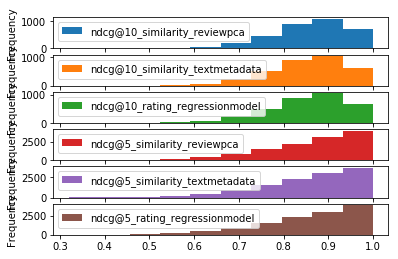

In [81]:
ndcg_scores = [pd.Series(i) for i in [ndcg_scores_1_10, ndcg_scores_2_10, ndcg_scores_3_10, ndcg_scores_1_5, ndcg_scores_2_5, ndcg_scores_3_5]]
ndcg_scores = pd.concat(ndcg_scores, axis=1)
ndcg_scores.columns = ['ndcg@10_similarity_reviewpca','ndcg@10_similarity_textmetadata','ndcg@10_rating_regressionmodel',\
                       'ndcg@5_similarity_reviewpca','ndcg@5_similarity_textmetadata','ndcg@5_rating_regressionmodel']

# save the NDCG scores to file
with open('ndcg_content_based.pkl','wb') as f:
    pickle.dump(ndcg_scores, f)

ndcg_scores.plot(kind='hist', subplots=True);
ndcg_scores.describe()

As shown, the recommendation ranking generated by cosine-similarity scores between user and restaurant based on their feature vectors extracted from restaurant reviews is consistently the best among all three ranking strategies, both for NDCG@top10 and for NDCG@top5. The ranking generated by cosine-similarity scores based on restaurant text metadata is the worse among all three strategies, also both for NDCG@top10 and for NDCG@top5.<br> 

This again, suggests that having additional restaurant metadata might not benefit the ranking quality, as concluded here.<br> This is likely due to the observation that many of the restaurant metadata information can actually be extracted from the restaurant reviews, thanks to the rich reviews the Yelp dataset has. With abdundent restaurant reviews, most restaurant features plus a lot more information indicating restaurant quality can be effectively picked up from reviews for building restaurant and user feature space.<br>

However, this might not be the case if a different dataset or application is given where reviews of items are limited. In those cases, other two strategies focusing on item metadata might be more suitable.<br>

NDCG between content-based recommender module and collaborative recommender module:<br>
As a cross comparison, the average NDCG@10 and NDCG@5 obtained on testset with no new user and restaurant by the collaborative module are 0.904 and 0.908, significantly higher than the NDCG scores achieved here using content-based recommendation strategies.

In [82]:
# free up temparary variables to save memory
sim_pca, sim_meta, rating_predict, rec, rev_count_by_user, user_id_of_interest = 0,0,0,0,0,0
ndcg_scores, ndcg_scores_1_10, ndcg_scores_2_10, ndcg_scores_3_10, ndcg_scores_1_5, ndcg_scores_2_5, ndcg_scores_3_5 = 0,0,0,0,0,0,0
train, test = 0,0

# 7. Implement content-based recommender module

Based on the ranking performance comparison in section \#6, the ranking strategy by descending cosine-similarity score between user and restaurant based on their review-based feature vectors outperforms other ranking strategies and will be used for implementing the content-based recommender module.

## 7.1 Update restaurant and user feature vectors using the the entire restaurant reviews data


Perviously, only 90% of the restaurant-related reviews are used as the trainset, and 10% of the reviews are reserved for testing. Here, to implement in the actual content-based module, the restaurant feature vectors are updated taking advantage of the entire restaurant reviews data.<br>

Similar to building the restaurant feature vectors, only 90% of the restaurant-related reviews are used as the trainset to aggregate user feature vectors, and the rest 10% are reserved for testing purposes. Here, the user feature vectors are also updated taking advantage of the entire restaurant reviews data.<br>

The updated restaurant and user feature vectors are saved to file for use in the actual recommender module.

### 7.1.1 Extract pcafeatures based on all restaurant-related reviews

In [83]:
%%time

# groupby business_id and concatenate all reviews of the same business together, reviews are separated by '###'
rev_by_rest = review_s.groupby('business_id').agg({'review_id': 'count', 'text': lambda i: '###'.join(i)}).rename(columns={'review_id':'review_count','text':'review_combined'})
rev_by_rest = rev_by_rest.reset_index()

# Tfidf to extract top 1000 features from restaurant reviews
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=1000) # limit to top 1000 words
X = vectorizer.fit_transform(rev_by_rest.review_combined)

# convert to a sparse dataframe
rest_revfeature = pd.SparseDataFrame(X)
rest_revfeature = rest_revfeature.set_index(rev_by_rest.business_id)
rest_revfeature.columns = vectorizer.get_feature_names()
rest_revfeature = rest_revfeature.fillna(0) # fill in missing values with 0 to use PCA

# feature reduction with PCA
from sklearn.decomposition import PCA
pca = PCA()
rest_pcafeature = pca.fit_transform(rest_revfeature)
# keep only top 300 PCA components which account for 80% of the variance
rest_pcafeature = pd.DataFrame(rest_pcafeature[:,:300], index=rest_revfeature.index, columns=[str(i) for i in np.arange(1,301)])
rest_pcafeature.columns.name = 'pca_components'

# rescale rest_pcafeature coefficients so all restaurant feature vectors share the same unit length of 1
rest_pcafeature['root_squared_sum'] = rest_pcafeature.apply(lambda row: np.sqrt(sum([i*i for i in row])), axis=1)
rest_pcafeature = rest_pcafeature.drop('root_squared_sum',axis=1).divide(rest_pcafeature.root_squared_sum, axis=0)

CPU times: user 12min 33s, sys: 13min 17s, total: 25min 50s
Wall time: 47min 47s


### 7.1.2 Aggregate user feature vector based on personal review ratings out of the entire restaurant review dataset

In [84]:
%%time

# build user preference profile by compute a weighted sum of the restaurant vectors for all rated restaurants by the user
# with the corresponding weights being the user’s rating of that restaurant
user_pcafeature = pd.merge(review_s[['user_id','business_id','stars']], rest_pcafeature, how='inner',left_on='business_id',right_index=True).drop('business_id', axis=1)
user_pcafeature.loc[:, '1':'300'] = user_pcafeature.loc[:,'1':'300'].multiply(user_pcafeature.stars, axis=0)

# sum up all component coefficients by user_id
user_pcafeature = user_pcafeature.drop('stars', axis=1).groupby('user_id').sum()

# rescale user_pcafeature coefficients so all user feature vectors share the same unit length of 1
user_pcafeature['root_squared_sum'] = user_pcafeature.apply(lambda row: np.sqrt(sum([i*i for i in row])), axis=1)
user_pcafeature = user_pcafeature.drop('root_squared_sum', axis=1).divide(user_pcafeature.root_squared_sum, axis=0)

CPU times: user 2min 28s, sys: 6min 26s, total: 8min 55s
Wall time: 19min 5s


### 7.1.3 Save the final restaurant and user feature vectors for use in the content-based recommender module

In [85]:
# save the user feature vector and restaurant feature vector to file

with open('rest_pcafeature_all.pkl','wb') as f:
    pickle.dump(rest_pcafeature, f)

# to save user_pcafeature, need to write in chucks of size smaller than 2GB due to a bug in Python 3
max_bytes = 2**31 - 1
bytes_out = pickle.dumps(user_pcafeature)
with open('user_pcafeature_all.pkl','wb') as f:
    for idx in range(0, len(bytes_out), max_bytes):
        f.write(bytes_out[idx:idx+max_bytes])

In [86]:
# free up temparary variables to save memory
rev_by_rest, vectorizer, rest_revfeature, rest_pcafeature, user_pcafeature, review_s, business = 0,0,0,0,0,0,0

## 7.2 Implementation of the content-based recommender module

For the actual implementation of the content-based module: <br> 
* first, the recommendation is initiated to all the open restaurant businesses in the 'business' catalog
* secondly, the restaurant and user feature vectors extracted from all the restaurant reviews in the 'review' dataset are loaded into the module
* thirdly, given the user_id of interest, all the cosine similarity scores are computed between this user and all the restaurants in the catalog, and added as a column to the recommendation list based on matching 'business_id'
* lastly, the recommendation list is filtered to unrated restaurants only based on the user_id of interest, and ranked by descending similarity scores to reach the final recommendation for the given user. 

In [87]:
import os.path
from sklearn.metrics.pairwise import linear_kernel

In [88]:
# the 'business' and 'review' datasets need to be imported for the content-based recommender module to operate
business = pd.read_csv('business_clean.csv')
review = pd.read_csv('review_clean.csv')
# extract a subset of reviews related to restaurants, since we are only interested in restaurant-type business
review_s = review[review.business_id.isin(business.business_id.unique())]
review = 0 # set review=None to free up memory

In [89]:
# adding 'adjusted_score' to the 'business' dataset, which adjusts the restaurnat average star ratings by the number of ratings it has
globe_mean = ((business.stars * business.review_count).sum())/(business.review_count.sum())
k = 22 # set strength k to 22, which is the 50% quantile of the review counts for all businesses
business['adjusted_score'] = (business.review_count * business.stars + k * globe_mean)/(business.review_count + k)

In [90]:
class Recommender:
    
    def __init__(self, n=5, original_score=False):
        """initiate a Recommender object by passing the desired number of recommendations to make, the default number is 10.
        By default, the adjusted score will be used for ranking; To rank by the original average rating of the restaurant, pass original_score=True
        """
        self.n = n # number of recommendations to make, default is 5
        self.original_score = original_score # boolean indicating whether the original average rating or the adjusted score is used
        # initiate a list of column names to display in the recommendation results
        self.column_to_display = ['state','city','name','address','attributes.RestaurantsPriceRange2','cuisine','style','review_count','stars','adjusted_score']
        
        # initiate the list of recommendations to be all the open restaurants from the entire catalog of 'business' dataframe sorted by the score of interest
        if self.original_score:  # set sorting criteria to the originial star rating
            score = 'stars'
        else:  # set sorting criteria to the adjusted score
            score = 'adjusted_score'
        self.recomm = business[business.is_open == 1].sort_values(score, ascending=False) 
        
    def display_recommendation(self):
        """ Display the list of top n recommended restaurants
        """
        if len(self.recomm) == 0:
            print("Sorry, there is no matching recommendations.")
        elif self.n < len(self.recomm):  # display only the top n from the recommendation list
            print("Below is a list of the top {} recommended restaurants for you: ".format(self.n))
            print(self.recomm.iloc[:self.n][self.column_to_display])
        else:  # display all if # of recommendations is less than self.n
            print("Below is a list of the top {} recommended restaurants for you: ".format(len(self.recomm)))
            print(self.recomm[self.column_to_display])
 
    #------------------------------------------------------------
    # personalized content-based filtering recommender module
    def content(self, user_id=None):
        """Passing of user_id is required if personalized recommendation is desired.
        """
        
        self.user_id = user_id # user_id for personalized recommendation using collaborative filtering 
        if self.user_id is None:
            print("no user_id is provided!")
            return None
        if len(self.user_id) != 22:
            print("invalid user id!")
            return None
        if self.user_id not in review_s.user_id.unique(): # check if previous restaurant rating/review history is available for the user_id of interest
            print("sorry, no personal data available for this user_id yet!")
            return []
        
        # initiate every time the module is called
        self.recomm = business[business.is_open ==1] # start with all open restaurants from the entire 'business' catalog
        self.column_to_display = ['state','city','name','address','attributes.RestaurantsPriceRange2',\
                                  'cuisine','style','review_count','stars','adjusted_score'] # reset the columns to display
        if 'similarity_score' in self.recomm.columns:
            self.recomm.drop('similarity_score', axis=1, inplace=True) # delete the column of 'cosine_similarity' if already present
        
        # load the saved restaurant pca feature vectors
        with open('rest_pcafeature_all.pkl', 'rb') as f:
            rest_pcafeature = pickle.load(f)
            
        # load the saved user pca feature vectors
        max_bytes = 2**31 - 1
        bytes_in = bytearray(0)
        input_size = os.path.getsize('user_pcafeature_all.pkl')
        with open('user_pcafeature_all.pkl','rb') as f: 
            for _ in range(0, input_size, max_bytes):
                bytes_in += f.read(max_bytes)
            user_pcafeature = pickle.loads(bytes_in)
        
        # predict personalized cosine similarity scores for the user_id of interest
        sim_matrix = linear_kernel(user_pcafeature.loc[user_id].values.reshape(1, -1), rest_pcafeature)
        sim_matrix = sim_matrix.flatten()
        sim_matrix = pd.Series(sim_matrix, index = rest_pcafeature.index)
        sim_matrix.name = 'similarity_score'
        
        # pairing the computed cosine similarity score with the business_id by matching the corresponding matrix indices of the business_id
        self.recomm = pd.concat([sim_matrix, self.recomm.set_index('business_id')], axis=1, join='inner').reset_index()
        
        # filter to unrated business_id only by the user_id of interest if a personal history is available      
        busi_rated = review_s[review_s.user_id == self.user_id].business_id.unique()
        self.recomm = self.recomm[~self.recomm.business_id.isin(busi_rated)]
               
        # sort the recommendation by the cosine similarity score in descending order
        self.recomm = self.recomm.sort_values('similarity_score', ascending=False).reset_index(drop=True)
           
        # add 'similarity_score' to the list of columns to display
        self.column_to_display.insert(0, 'similarity_score') 
        
        # display the list of top n recommendations
        self.display_recommendation()
        
        return self.recomm

## 7.3 Testing of the personalized content-based recommender module

In [91]:
%%time

# time needed to load in the restaurant and user feature vectors

with open('rest_pcafeature_all.pkl', 'rb') as f: # load the saved restaurant pca feature vectors
    rest_pcafeature = pickle.load(f)
            
max_bytes = 2**31 - 1
bytes_in = bytearray(0)
input_size = os.path.getsize('user_pcafeature_all.pkl')
with open('user_pcafeature_all.pkl','rb') as f:  # load the saved user pca feature vectors
    for _ in range(0, input_size, max_bytes):
        bytes_in += f.read(max_bytes)
    user_pcafeature = pickle.loads(bytes_in)

CPU times: user 3.07 s, sys: 10.4 s, total: 13.4 s
Wall time: 23.9 s


Note: the time needed to load the restaurant and user feature vectors is around 20 seconds.

In [92]:
%%time

# initiate a Recommender object
con = Recommender(n=10)

# test0: display only (same as no keywords)
print("------\nresult from test0 (display only): ")
con.display_recommendation()

# test1: no user id input
print("------\nresult from test1 (no user id input): ")
con.content();

# test 2: invalid user id input
print("------\nresult from test2 (invalid user id input): ")
con.content(user_id='928402');

------
result from test0 (display only): 
Below is a list of the top 10 recommended restaurants for you: 
      state             city                                  name  \
7464     AZ          Phoenix                       Little Miss BBQ   
31910    NV        Las Vegas                          Brew Tea Bar   
45401    NV        Las Vegas                            Gelatology   
7784     NV  North Las Vegas                          Poke Express   
28162    NV        Las Vegas                    Meráki Greek Grill   
2684     AZ             Mesa                        Worth Takeaway   
14567    NV        Las Vegas                Free Vegas Club Passes   
11521    NV        Las Vegas  Paranormal - Mind Reading Magic Show   
30972    NV        Las Vegas           Desert Wind Coffee Roasters   
46284    NV        Henderson                                HUMMUS   

                            address  attributes.RestaurantsPriceRange2  \
7464           4301 E University Dr              

In [93]:
%%time

# test 3: valid user id (no user data)
print("------\nresult from test3 (valid user id --- no user review data): ")
con.content(user_id='-NzChtoNOw706kps82x0Kg');

------
result from test3 (valid user id --- no user review data): 
sorry, no personal data available for this user_id yet!
CPU times: user 458 ms, sys: 418 ms, total: 876 ms
Wall time: 1.1 s


In [95]:
%%time

# test 4: valid user id (user has only one review)
print("------\nresult from test4 (valid user id --- user has only one review): ")
con.content(user_id='---89pEy_h9PvHwcHNbpyg');

------
result from test4 (valid user id --- user has only one review): 
Below is a list of the top 10 recommended restaurants for you: 
   similarity_score state       city                               name  \
0          0.920511    NV  Henderson      The Bar At Bermuda & St. Rose   
1          0.913473    NV  Las Vegas  The Bar @ Las Vegas Blvd & Wigwam   
2          0.912803    NV  Las Vegas      The Bar @ Tropicana & Durango   
3          0.859365    NV  Las Vegas            The Bar @Trails Village   
4          0.848265    NV  Las Vegas              Distill - A Local Bar   
5          0.847307    NV  Las Vegas              Distill - A Local Bar   
6          0.841570    NV  Henderson                    Remedy's Tavern   
7          0.814201    NV  Las Vegas                 Sunrise Casablanca   
8          0.813073    NV  Las Vegas                   Aces Bar & Grill   
9          0.803431    NV  Las Vegas                Cactus Jacks Saloon   

                          address  att

The best total time to return the recommendation is around 25 seconds, but the time needed to load the feature vectors is 20 seconds by itself. Therefore, to speed up the recommender's response time, an alternative way is to load in the restaurant and user feature vectors when initializing the recommender object (under the \__init\__ method). 

As shown, the personalized recommendation result features mid-price range bars of high ratings near Las Vegas, these are very personalized recommendations based on the user's only review of a 4-star nightlife bars in the mid-price range located in Las Vegas, and the user gives the bar a 5-star review with strong positive words, a clear indication of his/her preference.

In [97]:
%%time

# test 5: valid user id (user has over 100 reviews)
print("------\nresult from test5 (valid user id --- user has over 100 reviews): ")
con.content(user_id='Ox89nMY8HpT0vxfKGqDPdA');

------
result from test5 (valid user id --- user has over 100 reviews): 
Below is a list of the top 10 recommended restaurants for you: 
   similarity_score state       city                          name  \
0          0.656317    AZ    Gilbert              Joe's Farm Grill   
1          0.613937    AZ       Mesa                  Orchard Eats   
2          0.583544    AZ    Phoenix                 Welcome Diner   
3          0.575226    AZ    Phoenix  Wally's American Pub N Grill   
4          0.574281    AZ    Phoenix    Phoenix Public Market Cafe   
5          0.572199    AZ      Tempe      Tempe Public Market Cafe   
6          0.568653    AZ    Phoenix       Switch Restaurant & Bar   
7          0.568363    AZ    Phoenix                           FEZ   
8          0.568114    NV  Henderson        Henry's American Grill   
9          0.565331    AZ    Phoenix        St. Francis Restaurant   

                     address  attributes.RestaurantsPriceRange2  \
0      3000 E Ray Rd, Bld

As shown, the personalized recommendation list features popular restaurants (over 150 reviews) in the low-to-mid price range, featuring american style cuisines (pizza, burger, sandwiches), located in Arizona. These are very personalized recommendations based on the user's history of 120 restaurant reviews.